In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F  
import numpy as np
import json
import os
import cv2
import mediapipe as mp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")
else:
    print("CUDA is not available. Using CPU.")

NameError: name 'torch' is not defined

In [ ]:
class HandGestureDataset(Dataset):
    def __init__(self, data_dir):
        self.data = []
        self.labels = []
        
        for class_name in os.listdir(data_dir):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    if file_name.endswith('.json'):
                        file_path = os.path.join(class_dir, file_name)
                        with open(file_path, 'r') as f:
                            landmarks = json.load(f)
                        self.data.append(np.array(landmarks).flatten())
                        self.labels.append(class_name)
        
        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)
        self.labels = torch.tensor(self.encoded_labels, dtype=torch.long)
        
        self.idx_to_label = {i: label for i, label in enumerate(self.label_encoder.classes_)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def get_label_encoder(self):
        return self.label_encoder

    def get_class_distribution(self):
        return Counter(self.encoded_labels)

In [ ]:
class HandGestureModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(HandGestureModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#### Train functions

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm
import copy
import time
import numpy as np

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, scheduler, patience):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_loss_accuracy = np.inf
    best_test_accuracy = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stopping_counter = 0
    since = time.time()
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        model.eval()
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
        
        if scheduler:
            scheduler.step(test_loss)
            
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f} | lr: {current_lr:.6f}")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc
        
        if test_loss < best_loss_accuracy:
            best_loss_accuracy = test_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
            
        else:
            early_stopping_counter += 1
            print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
            if early_stopping_counter >= patience:
                print('Early stopping triggered.')
                model.load_state_dict(best_model_wts)
                time_elapsed = time.time() - since
                print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
                break
    
    # Load the best model weights before returning results
    model.load_state_dict(best_model_wts)
    return results

### Load dataset

In [ ]:
data_dir = r'D:\SignLanguage\NOTEBOOKS\LANDMARKS'
dataset = HandGestureDataset(data_dir)

In [ ]:
class_distribution = dataset.get_class_distribution()
print("Class distribution:")
for encoded_label, count in class_distribution.items():
    class_name = dataset.idx_to_label[encoded_label]
    print(f"{class_name}: {count}")

In [ ]:
total_samples = len(dataset)
num_classes = len(class_distribution)
min_class_size = min(class_distribution.values())
max_class_size = max(class_distribution.values())


print(f"\nTotal number of samples: {total_samples}")
print(f"Number of classes: {num_classes}")
print(f"Samples per class: min = {min_class_size}, max = {max_class_size}, average = {total_samples/num_classes:.2f}")


Total number of samples: 6334
Number of classes: 35
Samples per class: min = 136, max = 200, average = 180.97


In [22]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataset,test_dataset

(<torch.utils.data.dataset.Subset at 0x2304d5735e0>,
 <torch.utils.data.dataset.Subset at 0x2304acb3a90>)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader,test_loader

(<torch.utils.data.dataloader.DataLoader at 0x2304d3c7310>,
 <torch.utils.data.dataloader.DataLoader at 0x2304d484d30>)

### Training Phase

In [34]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
from torch.optim import Adam

EARLY_STOPPING_PATIENCE = 6

input_size = 63 
hidden_size = 128
num_classes = len(dataset.get_label_encoder().classes_)
model = HandGestureModel(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

trained_model = train(model, train_loader, train_loader, optimizer, loss_fn=criterion, epochs=num_epochs, scheduler=scheduler, patience=EARLY_STOPPING_PATIENCE)

d:\SignLanguage\.venv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4231 | train_acc: 0.0762 | test_loss: 2.9918 | test_acc: 0.1877 | lr: 0.001000
Epoch: 2 | train_loss: 2.5435 | train_acc: 0.2232 | test_loss: 1.9525 | test_acc: 0.4602 | lr: 0.001000
Epoch: 3 | train_loss: 1.8887 | train_acc: 0.3677 | test_loss: 1.4617 | test_acc: 0.5651 | lr: 0.001000
Epoch: 4 | train_loss: 1.5753 | train_acc: 0.4480 | test_loss: 1.1813 | test_acc: 0.6809 | lr: 0.001000
Epoch: 5 | train_loss: 1.3697 | train_acc: 0.5176 | test_loss: 0.9975 | test_acc: 0.7341 | lr: 0.001000
Epoch: 6 | train_loss: 1.2070 | train_acc: 0.5732 | test_loss: 0.8498 | test_acc: 0.7776 | lr: 0.001000
Epoch: 7 | train_loss: 1.0738 | train_acc: 0.6296 | test_loss: 0.7573 | test_acc: 0.8222 | lr: 0.001000
Epoch: 8 | train_loss: 0.9745 | train_acc: 0.6588 | test_loss: 0.6441 | test_acc: 0.8458 | lr: 0.001000
Epoch: 9 | train_loss: 0.8776 | train_acc: 0.6941 | test_loss: 0.5700 | test_acc: 0.8463 | lr: 0.001000
Epoch: 10 | train_loss: 0.8287 | train_acc: 0.7109 | test_loss: 

#### Loss Curve function

In [28]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

#### Visualize Loss Curve

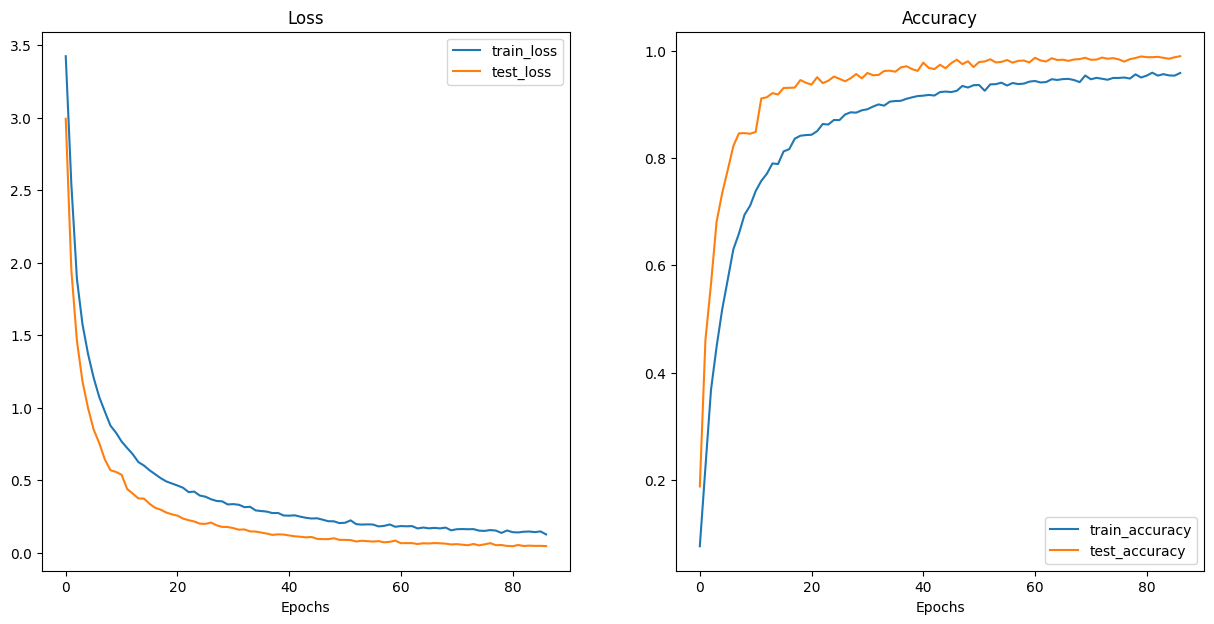

In [36]:
plot_loss_curves(trained_model)

In [ ]:
torch.save(model.state_dict(), 'models/landmark_model.pth')

#### Evaluation

In [37]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 98.82%


#### Extract landmarks from an image

In [67]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

In [68]:
def extract_landmarks(image_path):
    if not os.path.exists(image_path):
        print(f"Error: The file {image_path} does not exist.")
        return None
    
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to read the image at {image_path}")
            print("This might be due to:")
            print("1. The file is not an image.")
            print("2. The file is corrupted.")
            print("3. OpenCV doesn't support the image format.")
            return None
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)
        
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            landmarks = [[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]
            return np.array(landmarks).flatten()
        else:
            print("No hand detected in the image.")
            return None
    except Exception as e:
        print(f"An error occurred while processing the image: {str(e)}")
        return None

In [57]:
def predict_gesture(image_path):
    landmarks = extract_landmarks(image_path)
    if landmarks is None:
        return "No hand detected or error in image processing", 0.0
    
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(landmarks, dtype=torch.float32).unsqueeze(0).to(device)
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        predicted_class = dataset.get_label_encoder().inverse_transform(predicted.cpu().numpy())[0]
        return predicted_class, confidence.item()

In [77]:
image_path = r'D:\SignLanguage\NOTEBOOKS\DATASET\test\5\K_5 (49).jpg'

try:
    predicted_class, confidence = predict_gesture(image_path)
    print(f"Image: {image_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")
except Exception as e:
    print(f"An error occurred during prediction: {str(e)}")

print("\nDebugging Information:")
print(f"1. Does the file exist? {os.path.exists(image_path)}")
if os.path.exists(image_path):
    print(f"2. File size: {os.path.getsize(image_path)} bytes")
    print(f"3. File permissions: {oct(os.stat(image_path).st_mode)[-3:]}")
print("4. OpenCV version:", cv2.__version__)
print("5. Working directory:", os.getcwd())

Error: The file D:\SignLanguage\NOTEBOOKS\DATASET\test\5\K_5 (49).jpg does not exist.
Image: D:\SignLanguage\NOTEBOOKS\DATASET\test\5\K_5 (49).jpg
Predicted class: No hand detected
Confidence: 0.00%

Debugging Information:
1. Does the file exist? False
4. OpenCV version: 4.10.0
5. Working directory: d:\SignLanguage\NOTEBOOKS
